In [1]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import gsw
from scipy.ndimage.filters import gaussian_filter as gf

In [2]:
setup = "ESII_SO"
confi = "RCSI100.L55_ctlv30_030W"

We load the bathymetry and vertical grid created before to know the extent of the configurations domain.

In [3]:
ds_bathy = xr.open_dataset(setup + "-" + confi + "-bathymetry_and_mask.nc", engine='h5netcdf')
xnum = len(ds_bathy.x)
ynum = len(ds_bathy.y)
dx = ds_bathy.x.grid_spacing
dy = ds_bathy.y.grid_spacing

ds_z_axis = xr.open_dataset(setup + "-" + confi + "-vertical_grid.nc", engine='h5netcdf')
z = ds_z_axis["Z"].values
dz = ds_z_axis["drF"].values # thickness of cells

Define latitudinal and longitudinal range to use from WOA18 (the domain of the configuration is then assumed to span approximately this coordinate range for interpolation purposes).

In [4]:
lat_min = -75
lat_max = -35
lon_cen = -30

fake_lat = np.linspace(lat_min, lat_max, ynum)

In [5]:
woa1 = xr.open_mfdataset("/home/jrieck/WOA18/woa18_8594_[ts]0[1-9]_01.nc", 
                         decode_times=False, combine='by_coords', engine='h5netcdf').squeeze()
woa2 = xr.open_mfdataset("/home/jrieck/WOA18/woa18_8594_[ts]1[0-2]_01.nc", 
                         decode_times=False, combine='by_coords', engine='h5netcdf').squeeze()
woa_m = xr.concat([woa1, woa2], dim="time").sel(lat=slice(lat_min, lat_max)).sel(lon=lon_cen, method='nearest')

Need to fill up WOA18 data below 1500m with seasonal means, as no monthly climatological values exist for the deep ocean

In [8]:
woa_s = xr.open_mfdataset("/home/jrieck/WOA18/woa18_8594_[ts]1[3-6]_01.nc", 
                          decode_times=False, combine='by_coords', engine='h5netcdf').squeeze()
woa_s = woa_s.sel(lat=slice(lat_min, lat_max)).sel(lon=lon_cen, method='nearest')
# need to artificially extend seasonal climatology to do the interpolation
woa_s_before = woa_s.isel(time=-1)
woa_s_before["time"] = woa_s.isel(time=0).time - (woa_s.isel(time=1).time - woa_s.isel(time=0).time)
woa_s_after = woa_s.isel(time=0)
woa_s_after["time"] = woa_s.isel(time=-1).time + (woa_s.isel(time=1).time - woa_s.isel(time=0).time) 
woa_s_extended = xr.concat([woa_s_before, woa_s, woa_s_after], dim="time").chunk({"time": 6})
woa_mfroms = woa_s_extended.interp_like(woa_m.time)
woa_mfroms_deep = woa_mfroms.sel(depth=slice(1500.1, 6000))
woa_combine = xr.concat([woa_m, woa_mfroms_deep], dim="depth").chunk({"depth": 102})

In [9]:
woa_ws = woa_combine.where(~np.isnan(woa_combine.t_an.isel(depth=0)))

In [14]:
def create_noise(xnum, ynum, dy, cutoff, taper_length, max_val):
    n = taper_length
    s = ynum / (ynum * dy / cutoff)
    whitenoise = np.random.random(size=(ynum, xnum))
    fnoise = gf(whitenoise, sigma=s)
    fnoise -= np.mean(fnoise)
    k = np.arange(0, n + 1)
    taper1side = np.sin(np.pi * k / n) * n / (np.pi * k)
    taper1side[-1] = 0
    taperx = np.hstack((np.hstack((taper1side[:0:-1], np.ones(xnum - (2 * n)))), taper1side[1:]))
    tapery = np.hstack((np.hstack((taper1side[:0:-1], np.ones(ynum - (2 * n)))), taper1side[1:]))
    taper = tapery[:, None] * taperx[None, :]
    fnoise *= taper
    return fnoise / np.max(np.abs(fnoise)) * max_val

Create temperature profiles for the initial conditions:

In [15]:
# use profiles from woa18 and fill up in y- and z-directions
t_tmp = woa_ws.t_an.interpolate_na("lat").interpolate_na("depth")
t_tmp = t_tmp.interp(lat=fake_lat, depth=-z, kwargs={"fill_value": "extrapolate"}).fillna(1e3).compute()
jmin = (t_tmp < 1e3).argmax(dim='lat').compute()
jmax = (t_tmp[:, :, ::-1] < 1e3).argmax(dim='lat').compute()
jmax = jmax.where(jmax>0, other=1)
t_tmp1 = t_tmp.where(t_tmp.lat >= t_tmp.isel(lat=jmin).lat, other = t_tmp.isel(lat=jmin))
t_tmp = t_tmp1.where(((t_tmp1.lat < t_tmp1.isel(lat=-jmax).lat)), other = t_tmp1.isel(lat=-(jmax + 1)))

In [16]:
ones = np.ones((12, len(dz), ynum, xnum), dtype=np.float32)

In [17]:
temperature_3D = ones * t_tmp.values[:, :, :, None]
temperature_init = temperature_3D

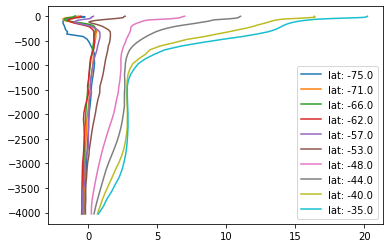

In [18]:
for yyy in np.linspace(0, ynum-1, 10):
    yy = int(np.floor(yyy))
    plt.plot(temperature_3D[0, :, yy, 0].squeeze(), z, label="lat: " + str(np.around(fake_lat[yy])))
plt.legend()

In [19]:
# use profiles from woa18 and fill up in y- and z-directions
s_tmp = woa_ws.s_an.interpolate_na("lat").interpolate_na("depth")
s_tmp = s_tmp.interp(lat=fake_lat, depth=-z, kwargs={"fill_value": "extrapolate"}).fillna(1e3).compute()
jmin = (s_tmp < 1e3).argmax(dim='lat').compute()
jmax = (s_tmp[:, :, ::-1] < 1e3).argmax(dim='lat').compute()
jmax = jmax.where(jmax>0, other=1)
s_tmp1 = s_tmp.where(s_tmp.lat >= s_tmp.isel(lat=jmin).lat, other = s_tmp.isel(lat=jmin))
s_tmp = s_tmp1.where(((s_tmp1.lat < s_tmp1.isel(lat=-jmax).lat)), other = s_tmp1.isel(lat=-(jmax + 1)))

In [20]:
salinity_3D = ones * s_tmp.values[:, :, :, None]
salinity_init = salinity_3D + create_noise(xnum, ynum, dy, 60, 10, 0.01)

/tmp/ipykernel_1178666/278855516.py:8: RuntimeWarning: invalid value encountered in true_divide
  taper1side = np.sin(np.pi * k / n) * n / (np.pi * k)


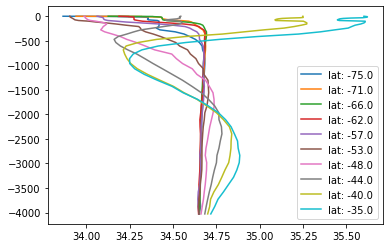

In [21]:
for yyy in np.linspace(0, ynum-1, 10):
    yy = int(np.floor(yyy))
    plt.plot(salinity_3D[6, :, yy, 0].squeeze(), z, label="lat: " + str(np.around(fake_lat[yy])))
plt.legend()

The January fields of these variables created above will serve as initial conditions for our model, the monthly climatology is used for the restoring along the northern boundary.

In [22]:
temperature_initial = temperature_init[0:1,...]
salinity_initial = salinity_init[0:1,...]

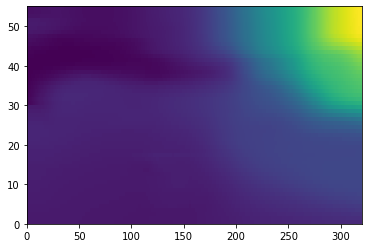

In [23]:
plt.pcolormesh(np.flipud(temperature_initial[0,:,:,0]))

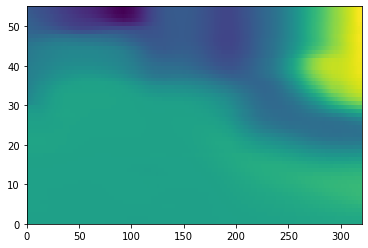

In [24]:
plt.pcolormesh(np.flipud(salinity_initial[0,:,:,0]))

In [29]:
temperature_3D.astype(">f4").tofile(setup + "-" + confi + "-woa18_temperature_3D.bin")
salinity_3D.astype(">f4").tofile(setup + "-" + confi + "-woa18_salinity_3D.bin")
temperature_initial.astype(">f4").tofile(setup + "-" + confi + "-woa18_temperature_initial.bin")
salinity_initial.astype(">f4").tofile(setup + "-" + confi + "-woa18_salinity_initial.bin")

In [30]:
ds_out = xr.Dataset(data_vars={"temperature": (("t", "z", "y", "x"), temperature_3D),
                               "salinity": (("t", "z", "y", "x"), salinity_3D)},
                    coords = {"t": (("t"), np.arange(0,12)),
                              "z": (("z"), z),
                              "y": (("y"), np.linspace(dy / 2, (ynum * dy) - dy / 2, ynum)),
                              "x": (("x"), np.linspace(dx / 2, (xnum * dx) - dx / 2, xnum))})
ds_out["temperature"].attrs = {"standard_name": "sea_water_potential_temperature",
                           "units": "degree C"}
ds_out["salinity"].attrs = {"standard_name": "sea_water_salinity",
                        "units": "1e-03"}
ds_out["z"].attrs = {"standard_name": "depth", 
                 "long_name": "vertical coordinate of cell center",
                 "units": "m",
                 "positive": "up",
                 "axis": "Z"}
ds_out["y"].attrs = {"long_name": "y coordinate",
                 "units": "km",
                 "axis": "Y",
                 "grid_spacing": dy}
ds_out["x"].attrs = {"long_name": "x coordinate",
                 "units": "km",
                 "axis": "X",
                 "grid_spacing": dx}

In [31]:
ds_out.to_netcdf(setup + "-" + confi + "-woa18_temperature_and_salinity_3D.nc", engine='h5netcdf')

/home/jrieck/.venv/py39/lib/python3.9/site-packages/h5netcdf/core.py:481: H5pyDeprecationWarning: other_ds.dims.create_scale(ds, name) is deprecated. Use ds.make_scale(name) instead.
  h5ds.dims.create_scale(h5ds, scale_name)
